In [1]:
import keras
from logging import info
import sys
import numpy as np
sys.path.append('..')
import condense
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# Construct a tf.data.Dataset
ds = tfds.load('iris', split='train', shuffle_files=True, as_supervised=True)
ds = ds.repeat()

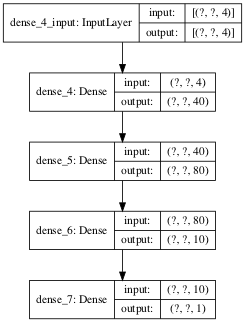

In [2]:
model = keras.models.load_model('./iris.h5')
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=60)

# Augment Model with Masking Layers

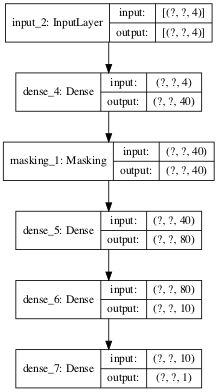

In [47]:
def insert_mask(model):
    new = keras.models.Sequential(layers=[
        keras.Input(shape=(None,4))
    ])
    new.add(model.layers[0])
    new.add(keras.layers.Masking(mask_value=0.2))


    for layer in model.layers[1:]:
        new.add(layer)
        info('Added Layer')
#         new.add(keras.layers.Masking(mask_value=0.0))
        info('Added Masking Layer')
    new.build()
    return new


new = insert_mask(model)
keras.utils.plot_model(new, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=60)

# Retraining Model with Masked Layers

Text(0.5, 1.0, 'Training Diff')

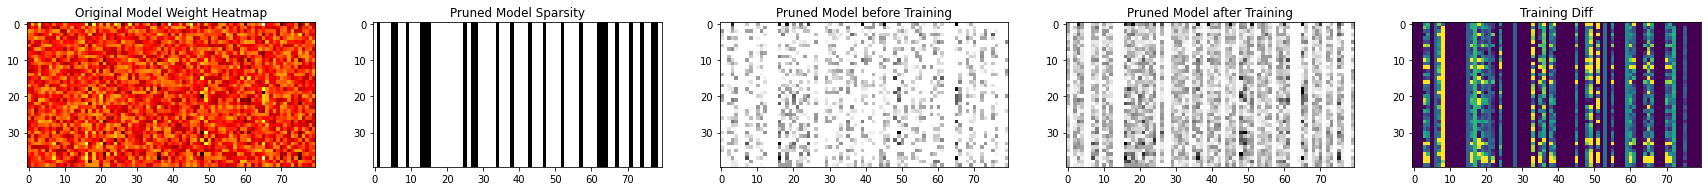

In [48]:
layer = 2

plt.figure(1, figsize=(30,3))

plt.subplot(151)
plt.imshow(model.get_weights()[layer], cmap='hot')
plt.title('Original Model Weight Heatmap')

pruned = condense.one_shot(new, .3)
pruned.compile('adam', 'mse')

plt.subplot(152)
plt.imshow(pruned.get_weights()[layer] == 0.0, cmap='binary')
plt.title('Pruned Model Sparsity')
pre_training = pruned.get_weights()[layer]

plt.subplot(153)
plt.imshow(pruned.get_weights()[layer], cmap='binary', vmin=0.0, vmax=.5)
plt.title('Pruned Model before Training')


pruned.fit(ds.batch(30), epochs=15, steps_per_epoch=100, verbose=0)

plt.subplot(154)
plt.imshow(np.abs(pruned.get_weights()[layer]), cmap='binary', vmin=0.0, vmax=.5)
plt.title('Pruned Model after Training')

plt.subplot(155)
plt.imshow(np.abs(np.subtract(pruned.get_weights()[layer], pre_training)), vmax=0.02)
plt.title('Training Diff')

Text(0.5, 1.0, 'Pre Training Sparsity')

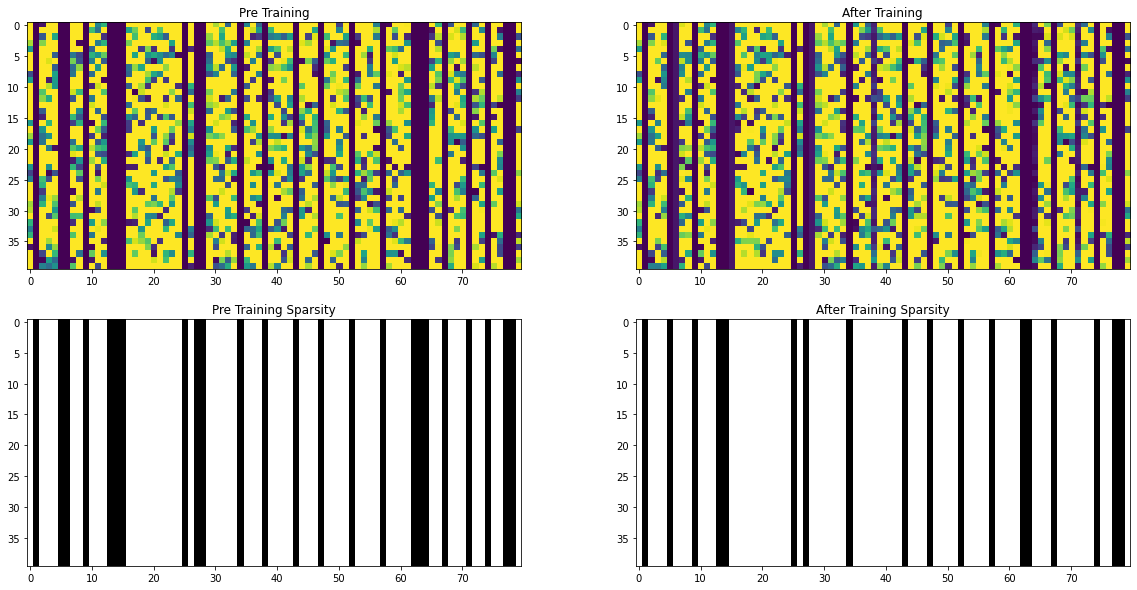

In [57]:
plt.figure(2, figsize=(20,10))

plt.subplot(221)
plt.imshow(np.abs(pre_training), vmin=0, vmax=0.1)
plt.title("Pre Training")

plt.subplot(222)
plt.imshow(np.abs(pruned.get_weights()[layer]), vmin=0, vmax=0.1)
plt.title("After Training")

plt.subplot(224)
plt.imshow(pruned.get_weights()[layer] != 0, cmap='gray')
plt.title("After Training Sparsity")

plt.subplot(223)
plt.imshow(pre_training != 0, cmap='gray')
plt.title("Pre Training Sparsity")

###### plt.figure(3, figsize=(20,10))
plt.imshow(np.abs(np.subtract(pruned.get_weights()[layer], pre_training)), vmax=0.03)
plt.title('Diff')